# Machine Learning: Logistic Regression

Submitted by Mary Franczine Tan

Applied Physics 157

AY 2022-2023 2nd Semester

In [1]:
# import packages

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.measure import regionprops, label, regionprops_table
from skimage.util import img_as_ubyte

## Data Preparation

Since we're dealing with similar dataset, I used the same method of image pre-processing as in my code for my perceptron model. The main difference is in the `getFeatures` function, which now returns the mean value in the image's R and Green channels. 

Just as a note, I also encountered some problems with the masked image that the `processImage` function returns. It returns the masked image with a white background, when it should be black. After looking at the array values, however, it has the correct value of zeroes. So I simply ignored this error in the image display since the values are what I need.

I'm using a training dataset of 500 images - 250 fresh and 250 rotten. For the testing, I'll be using 100 images - 50 fresh and 50 rotten.

In [2]:
# extract filenames 

fresh_filenames = sorted(glob.glob('train/freshbanana/*.png'))
rotten_filenames = sorted(glob.glob('train/rottenbanana/*.png'))

In [3]:
# segment image

def processImage(img):
    """
        performs thresholding and masking on an image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert image to grayscale
    gray[np.where(gray < 50)] = gray.max() # turn black background portions to white
    
    blur = cv2.GaussianBlur(gray, (5, 5), 0) # apply gaussian blur to image
    ret, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # segment using otsu's method
    
    th2 = cv2.bitwise_not(th) # invert threshold 
    thresh1d = cv2.morphologyEx(th2, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8), iterations = 2) # erode threshold
    
    _, _, layers = img.shape # get number of img channels
    
    if layers == 3: # if image has 3 channels
        thresh = cv2.merge((thresh1d, thresh1d, thresh1d)) # create 3-layer threshold for masking
    elif layers == 4: # if image has 4 channels
        thresh = cv2.merge((thresh1d, thresh1d, thresh1d, thresh1d)) # create 4-layer threshold for masking
    
    masked = cv2.bitwise_and(img, thresh) # mask image
    #masked[np.where(masked == masked.max())] = 0
    
    return masked, thresh1d

In [4]:
def removeBlackBG(img):
    """
        removes black background and turns it white
    """
    
    img[np.where(img == 0)] = img.max()
    
    return img

In [5]:
# extract image features

def getFeatures(file):
    """
        reads image, perform pre-processing, and get its features
    """
    
    orig = img_as_ubyte(plt.imread(file)) # read image as uint8 type
    img, bnw = processImage(orig) # segment image
    
    R = img[...,0] 
    Rmean = R[np.nonzero(R)].mean()
    G = img[...,1]
    Gmean = G[np.nonzero(G)].mean()
    
    return Rmean, Gmean

In [6]:
# create dataframe of the training data

train_features = [] # create empty list

for file in fresh_filenames: # append apples data to list
    fruit = 'ripe' # set type of freshness
    target = 1 # set target value
    average_red, average_green = getFeatures(file) # set feature values
    train_features.append([fruit, average_red, average_green, target]) # append to list
    
for file in rotten_filenames:
    fruit = 'rotten' # set type of freshness
    target = 0 # set target valye
    average_red, average_green = getFeatures(file) # set feature values
    train_features.append([fruit, average_red, average_green, target]) # append to list
    
train = pd.DataFrame(train_features, columns = ['type', 'x1', 'x2', 'y']) # create dataframe
train.x1 = train.x1 / train.x1.max() # normalize x1
train.x2 = train.x2 / train.x2.max() # normalize x2
display(train.head()) # show head of dataframe 

,type,x1,x2,y
0,ripe,0.975462,0.943187,1
1,ripe,0.955542,0.921663,1
2,ripe,0.951425,0.881859,1
3,ripe,0.995674,0.998909,1
4,ripe,0.954293,0.851984,1


## Model Training

The same method of training the perceptron model is also used in logistic regression. The main difference is that instead of using a step function, we use a sigmoid function instead. This will return a continuous set of data, instead of binary values only. And this type of data is what we want since we're looking for the probability that a fruit is fresh or not, with values closer to 1 being more fresh.

Here, we also track the performance of each epoch using __cross entropy loss__, which is given by the equation

$$
    \text{loss} = - (y \log_{10}{\hat{y}} + (1 - y) \log_{10}{(1 - \hat{y})})
$$

In [7]:
# include constant bias input
train['x0'] = 1 

# set initial weights
weights = [0.4, 0.4, 0.4] # w0, w1, w2

# set learning rate
n = 0.1

# reorder dataframe
train = train[['type', 'x0', 'x1', 'x2', 'y']]

In [8]:
# get weighted sum
def getW_sum(feature, weights):
    return np.dot(feature, weights)

def sigmoidFunction(weighted_sum):
    
    return 1 / (1 + np.exp(- 12 * (weighted_sum - 0.5 )))

In [9]:
def updateWeight(feature, weights, target, prediction):
    
    new_weights = []
    for x, w in zip(feature, weights):
        new_w = w + n * (target - prediction) * x
        new_weights.append(new_w)
        
    return new_weights

In [10]:
def crossEntropy(target, prediction):
    return -(target*np.log10(prediction) + (1-target)*np.log10(1-prediction))

In [11]:
# create list for errors per epoch
epoch_errors = []

def train_model(df, weights, epochs):
    
    for e in range(epochs+1):
        indiv_loss = []
        
        for i in range(len(df)):
            feature = df.loc[i][1:4]
            target = df.loc[i][4]
            w_sum = getW_sum(feature, weights)
            prediction = sigmoidFunction(w_sum)
            loss = crossEntropy(target, prediction)
            indiv_loss.append(loss)
            weights = updateWeight(feature, weights, target, prediction)
        
        epoch_errors.append(np.mean(indiv_loss))
    
    return weights

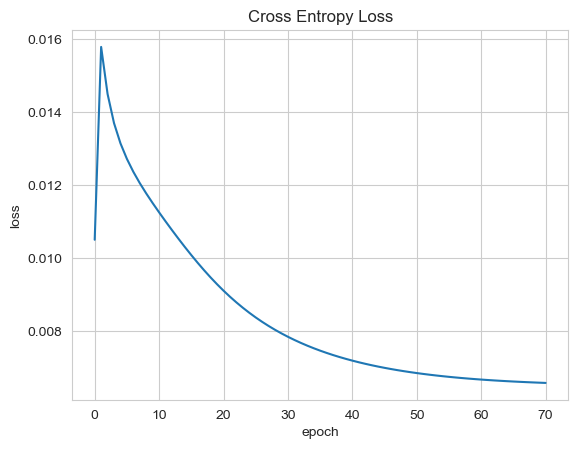

In [12]:
epoch_errors = []

# train model, get new weights
new_weights = train_model(train, weights, 70)

# plot errors per epoch 
sns.set_style('whitegrid')
plt.plot(epoch_errors)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.savefig('logreg_images/epochErrors')

While the goal is to simply give the probability that a fruit is fresh, I decided to still perform binary classification on the dataset simply to track the model's performance. We do this by solving for the decision line and classifiying the fruits by ripe or rotten using that. I've set the threshold to 0.4 since, from a visual analysis, it seems to better separate the group of fresh and rotten fruits. 

In [13]:
def decisionLine(x, weights):
    """
        returns the y for each x in the decision line
    """
    
    slope = - weights[1] / weights[2]
    intercept = (0.4 - weights[0])/ weights[2]
    
    return intercept + slope * x

x = np.linspace(0, 1, 10)
y = decisionLine(x, new_weights)

In [29]:
def confusionMatrix(data):
    
    tp = len(data[(data['y'] == 1) & (data['y_hat'] == 1)])
    tn = len(data[(data['y'] == 0) & (data['y_hat'] == 0)])
    fp = len(data[(data['y'] == 0) & (data['y_hat'] == 1)])
    fn = len(data[(data['y'] == 1) & (data['y_hat'] == 0)])
    
    print('true positive: ' + str(tp))
    print('true negative: ' + str(tn))
    print('false positive: ' + str(fp))
    print('false negative: ' + str(fn))
    print('accuracy: ' + str((tp + tn) / len(data)))

In [15]:
# get weighted sum using trained weights
pd.options.mode.chained_assignment = None  # default='warn'
train['w_sum'] = getW_sum(train[['x0', 'x1', 'x2']], new_weights)

# get predicted values
train['p'] = [sigmoidFunction(i) for i in train['w_sum']] # get probability
train['y_hat'] = train['x2'] > decisionLine(train['x1'], new_weights) # classify using decision line
train['y_hat'] = train['y_hat'].astype(int)

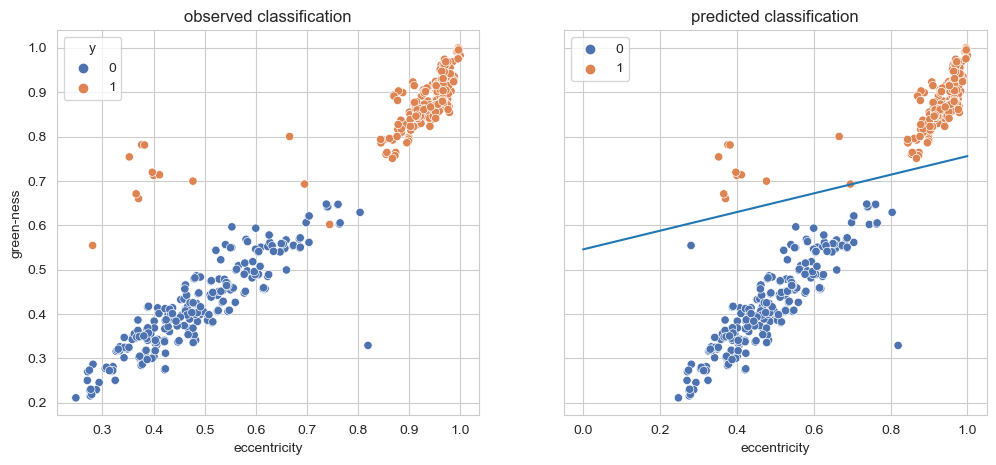

In [16]:
# plot the observed and predicted classification

fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharey = True)

sns.scatterplot(ax = ax[0], data = train, x = 'x1', y = 'x2', hue = 'y', palette = 'deep') # observed
sns.scatterplot(ax=ax[1], data = train, x = 'x1', y = 'x2', hue = 'y_hat', palette = 'deep') # predicted
sns.lineplot(ax = ax[1], x = x, y = y) # decision line
ax[0].set_title('observed classification')
ax[1].set_title('predicted classification')
ax[0].set_xlabel('eccentricity')
ax[0].set_ylabel('green-ness')
ax[1].set_xlabel('eccentricity')
ax[1].set_ylabel('green-ness')
plt.savefig('logreg_images/trainPlot')

In [30]:
print('training data - confusion matrix')
confusionMatrix(train)

training data - confusion matrix
true positive: 248
true negative: 250
false positive: 0
false negative: 2
accuracy: 0.996


We can see that the model has __0.996 accuracy__ on the training dataset.

## Model Testing

In [18]:
fresh_test = sorted(glob.glob('test/freshbanana/*.png'))
rotten_test = sorted(glob.glob('test/rottenbanana/*.png'))

In [19]:
# create dataframe of the testing data

test_features = [] # create empty list

for file in fresh_test: # append apples data to list
    fruit = 'ripe' # set type
    target = 1 # set target value
    eccentricity, green = getFeatures(file) # set feature values
    test_features.append([fruit, eccentricity, green, target]) # append to list
    
for file in rotten_test:
    fruit = 'rotten' # set type of fruit
    target = 0 # set target valye
    eccentricity, green = getFeatures(file) # set feature values
    test_features.append([fruit, eccentricity, green, target]) # append to list
    
test = pd.DataFrame(test_features, columns = ['fruit', 'x1', 'x2', 'y']) # create dataframe
test.x1 = test.x1 / test.x1.max() # normalize x2
test.x2 = test.x2 / test.x2.max() # normalize x2


test['x0'] = 1 # include constant bias input
test = test[['fruit', 'x0', 'x1', 'x2', 'y']] # reorder dataframe
display(test.head()) # show head of dataframe 

,fruit,x0,x1,x2,y
0,ripe,1,0.980235,0.946781,1
1,ripe,1,0.951800,0.845824,1
2,ripe,1,0.967344,0.881313,1
3,ripe,1,0.952422,0.882559,1
4,ripe,1,0.938828,0.912787,1


In [20]:
# get weighted sum using trained weights
test['w_sum'] = getW_sum(test[['x0', 'x1', 'x2']], new_weights)

# get prediction of fruit
test['p'] = [sigmoidFunction(w_sum) for w_sum in test['w_sum']]
test['y_hat'] = test['x2'] > decisionLine(test['x1'], new_weights) # classify using decision line
test['y_hat'] = test['y_hat'].astype(int)

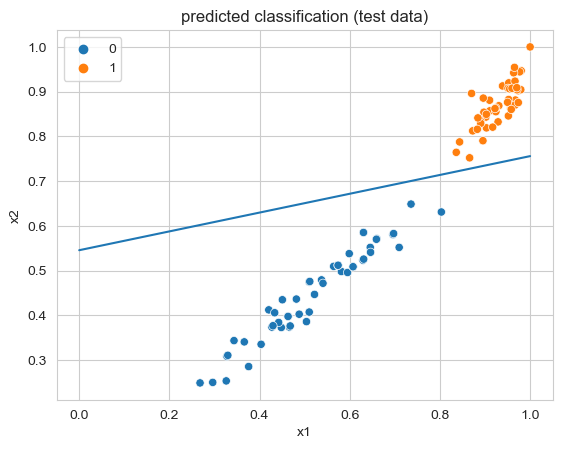

In [21]:
# plot classification
sns.scatterplot(data = test, x = 'x1', y = 'x2', hue = test['y_hat'])
sns.lineplot(x = x, y = y) # decision line
plt.title('predicted classification (test data)')
plt.savefig('logreg_images/testPlot')

In [31]:
print('testing data - confusion matrix')
confusionMatrix(test)

testing data - confusion matrix
true positive: 50
true negative: 50
false positive: 0
false negative: 0
accuracy: 1.0


We can see that the model has __1.0 accuracy__ on the testing dataset.

## Returning Freshness Probability

Since the main goal is to give the probability that a fruit is fresh, I've made the function `isFresh` to show the image and its freshness probability given a filename.

In [23]:
def isFresh(index, file):
    
    img = plt.imread(file)
    p = test.loc[index]['p']
    
    plt.imshow(img)
    plt.title('Probability it\'s ripe: ' + str(round(p * 100)) + '%')

In [24]:
# combine test files into one list
test_files = fresh_test + rotten_test

# set random seed
np.random.seed(1)

# generate indices
i, j, k = np.random.randint(0, 100, 3)

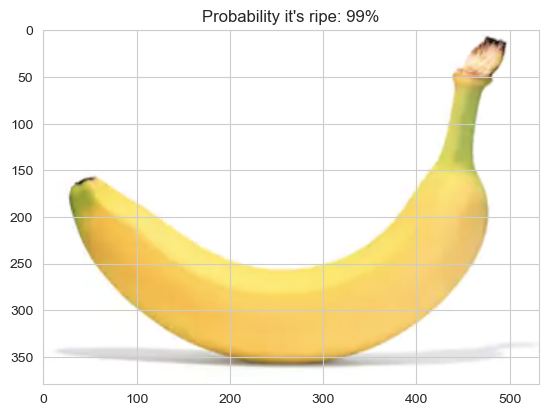

In [25]:
isFresh(i, test_files[i])
plt.savefig('logreg_images/prob1')

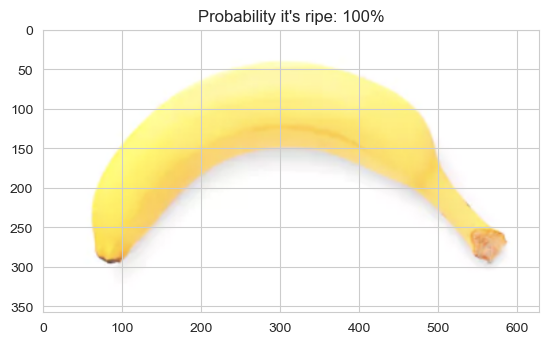

In [26]:
isFresh(j, test_files[j])
plt.savefig('logreg_images/prob2')

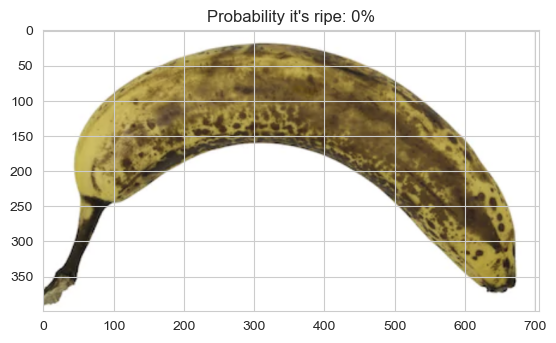

In [27]:
isFresh(k, test_files[k])
plt.savefig('logreg_images/prob3')

## Sources

Aside from the sources also used in my perceptron code, I've used the following:

- Cross Entropy Loss from Simplified Python [youtube tutorial](https://www.youtube.com/watch?v=EJRFP3WmS6Q&list=PLqXS1b2lRpYTpUIEu3oxfhhTuBXmMPppA&index=4)

In [ ]:
tra